# PID Control

In [12]:
# -----------
# User Instructions
#
# Define a function smooth that takes a path as its input
# (with optional parameters for weight_data, weight_smooth,
# and tolerance) and returns a smooth path. The first and 
# last points should remain unchanged.
#
# Smoothing should be implemented by iteratively updating
# each entry in newpath until some desired level of accuracy
# is reached. The update should be done according to the
# gradient descent equations given in the instructor's note
# below (the equations given in the video are not quite 
# correct).
# -----------

from copy import deepcopy

# thank you to EnTerr for posting this on our discussion forum
def printpaths(path,newpath):
    for old,new in zip(path,newpath):
        print ('['+ ', '.join('%.3f'%x for x in old) + 
               '] -> ['+ ', '.join('%.3f'%x for x in new) +']')

# Don't modify path inside your function.
path = [[0, 0],
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001):

    # Make a deep copy of path into newpath
    newpath = deepcopy(path)

    #######################
    ### ENTER CODE HERE ###
    #######################
    while True:
        totalChange = 0.
        for i in range(len(path)):
            if i != 0 and i != (len(path) - 1):
                for dim in range(len(path[i])):
                    oldVal = newpath[i][dim]
                    newpath[i][dim] = newpath[i][dim] + \
                        weight_data * (path[i][dim] - newpath[i][dim]) + \
                        weight_smooth * (newpath[i+1][dim] + newpath[i-1][dim] - 2 * newpath[i][dim])
                    totalChange += abs(oldVal - newpath[i][dim])
        if totalChange < tolerance:
            break

    return newpath # Leave this line for the grader!

printpaths(path,smooth(path))

[0.000, 0.000] -> [0.000, 0.000]
[0.000, 1.000] -> [0.021, 0.979]
[0.000, 2.000] -> [0.149, 1.851]
[1.000, 2.000] -> [1.021, 1.979]
[2.000, 2.000] -> [2.000, 2.000]
[3.000, 2.000] -> [2.979, 2.021]
[4.000, 2.000] -> [3.851, 2.149]
[4.000, 3.000] -> [3.979, 3.021]
[4.000, 4.000] -> [4.000, 4.000]


## P Control

In [14]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# Note that tau is called "param" in the function
# below.
#
# Your code should print output that looks like
# the output shown in the video. That is, at each step:
# print myrobot, steering
#
# Only modify code at the bottom!
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        res = robot()
        res.length = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            res.x = self.x + distance2 * np.cos(self.orientation)
            res.y = self.y + distance2 * np.sin(self.orientation)
            res.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * np.pi)
            res.x = cx + (np.sin(res.orientation) * radius)
            res.y = cy - (np.cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

def run(param):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    speed = 1.0 # motion distance is equalt to speed (we assume time = 1)
    N = 100 

    for i in range(N):  
        crocktrack_error = myrobot.y
        steer = - param * crocktrack_error
        myrobot = myrobot.move(steer, speed)
        print( myrobot, steer )

run(0.1)

[x=1.00000 y=0.99749 orient=6.27817] -0.1
[x=1.99997 y=0.98997 orient=6.27316] -0.0997491638459
[x=2.99989 y=0.97747 orient=6.26820] -0.0989972950612
[x=3.99973 y=0.96003 orient=6.26330] -0.0977469440459
[x=4.99948 y=0.93774 orient=6.25848] -0.0960031957433
[x=5.99912 y=0.91068 orient=6.25378] -0.0937736475381
[x=6.99861 y=0.87900 orient=6.24921] -0.0910683732206
[x=7.99796 y=0.84283 orient=6.24481] -0.0878998733516
[x=8.99714 y=0.80235 orient=6.24058] -0.0842830124796
[x=9.99614 y=0.75775 orient=6.23656] -0.0802349437746
[x=10.99497 y=0.70925 orient=6.23277] -0.0757750217292
[x=11.99360 y=0.65707 orient=6.22921] -0.0709247036578
[x=12.99206 y=0.60149 orient=6.22592] -0.0657074407797
[x=13.99033 y=0.54275 orient=6.22291] -0.060148559709
[x=14.98843 y=0.48116 orient=6.22020] -0.0542751351986
[x=15.98637 y=0.41701 orient=6.21779] -0.0481158549857
[x=16.98416 y=0.35062 orient=6.21570] -0.0417008775783
[x=17.98183 y=0.28231 orient=6.21395] -0.0350616837984
[x=18.97938 y=0.21242 orient=6.21

## PID Control

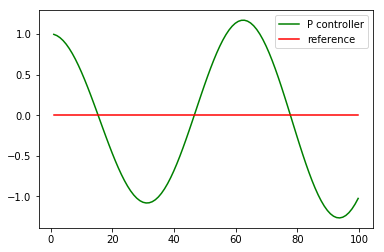

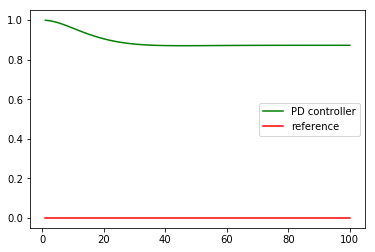

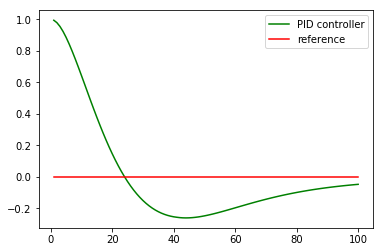

In [5]:
# -----------
# User Instructions
#
# Implement a PD controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)
#
# Your code should print output that looks like
# the output shown in the video.
#
# Only modify code at the bottom!
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt
from math import pi
# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        # res = Robot()
        # res.length = self.length
        # res.steering_noise = self.steering_noise
        # res.distance_noise = self.distance_noise
        # res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

# previous P controller
def run_p(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory

def run_pd(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    cte = robot.y
    for i in range(n):
        cte_diff = robot.y - cte
        cte = robot.y
        steer = -tau_p*cte - tau_d*cte_diff
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)   
    return x_trajectory, y_trajectory

def run_pid(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    cte = robot.y
    cte_total = 0
    # TODO: your code here
    for i in range(n):
        cte_diff = robot.y - cte
        cte = robot.y
        cte_total += cte
        steer = -tau_p*cte - tau_d*cte_diff - tau_i*cte_total
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)   
    return x_trajectory, y_trajectory

robot = Robot()
robot.set(0, 1, 0)

x_trajectory, y_trajectory = run_p(robot, 0.20)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='P controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
plt.show()

robot = Robot()
robot.set(0, 1, 0)

x_trajectory, y_trajectory = run_pd(robot, 0.2, 3.0)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
plt.show()

robot = Robot()
robot.set(0, 1, 0)

x_trajectory, y_trajectory = run_pid(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
plt.show()

## PID(steer draft)

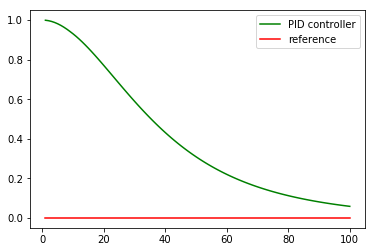

In [7]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Your code should print a list that looks just like
# the list shown in the video.
#
# Only modify code at the bottom!
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        # res = Robot()
        # res.length = self.length
        # res.steering_noise = self.steering_noise
        # res.distance_noise = self.distance_noise
        # res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

robot = Robot()
robot.set(0, 1, 0)

robot.set_steering_drift(10.0/180.0*pi)

def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    cte = robot.y
    cte_total = 0
    # TODO: your code here
    for i in range(n):
        cte_diff = robot.y - cte
        cte = robot.y
        cte_total += cte
        steer = -tau_p*cte - tau_d*cte_diff - tau_i*cte_total
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)   
    return x_trajectory, y_trajectory

x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()
plt.show()

## Twiddle

Iteration 0, best error = 8315.955485215645, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 1, best error = 0.0434970807256939, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 2, best error = 0.03065437362443958, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 3, best error = 0.007677320020068962, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 4, best error = 0.0032201674271162446, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 5, best error = 0.0016645945527960435, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 6, best error = 0.0009761080831682494, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 7, best error = 0.0006163432367765914, params = [2.9331227688652457, 10.326589894591526, 0.49316041639454505]
Iteration 8, best error = 0.00041102748054356214, 

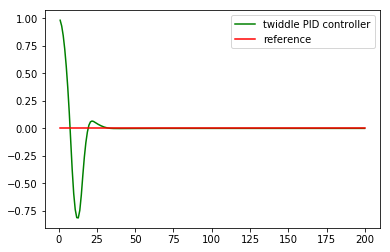

In [5]:
# ----------------
# User Instructions
#
# Implement twiddle as shown in the previous two videos.
# Your accumulated error should be very small!
#
# Your twiddle function should RETURN the accumulated
# error. Try adjusting the parameters p and dp to make
# this error as small as possible.
#
# Try to get your error below 1.0e-10 with as few iterations
# as possible (too many iterations will cause a timeout).
# No cheating!
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        # res = Robot()
        # res.length = self.length
        # res.steering_noise = self.steering_noise
        # res.distance_noise = self.distance_noise
        # res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run


def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot


# NOTE: We use params instead of tau_p, tau_d, tau_i
def run(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = (cte - prev_cte) / speed
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # TODO: Add code here
    # Don't forget to call `make_robot` before you call `run`!
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run(robot, p)

    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}, params = {}".format(it, best_err, params))
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p


params = twiddle()
robot = make_robot()
x_trajectory, y_trajectory, err = run(robot, params)
n = len(x_trajectory)

%matplotlib inline
plt.plot(x_trajectory, y_trajectory, 'g', label='twiddle PID controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()

## Problem Set1

In [8]:
# -------------
# User Instructions
#
# Here you will be implementing a cyclic smoothing
# algorithm. This algorithm should not fix the end
# points (as you did in the unit quizzes). You  
# should use the gradient descent equations that
# you used previously.
#
# Your function should return the newpath that it
# calculates.
#
# Feel free to use the provided solution_check function
# to test your code. You can find it at the bottom.
#
# --------------
# Testing Instructions
# 
# To test your code, call the solution_check function with
# two arguments. The first argument should be the result of your
# smooth function. The second should be the corresponding answer.
# For example, calling
#
# solution_check(smooth(testpath1), answer1)
#
# should return True if your answer is correct and False if
# it is not.

from math import *
from copy import deepcopy

# Do not modify path inside your function.
path=[[0, 0], 
      [1, 0],
      [2, 0],
      [3, 0],
      [4, 0],
      [5, 0],
      [6, 0],
      [6, 1],
      [6, 2],
      [6, 3],
      [5, 3],
      [4, 3],
      [3, 3],
      [2, 3],
      [1, 3],
      [0, 3],
      [0, 2],
      [0, 1]]

############# ONLY ENTER CODE BELOW THIS LINE ##########

# ------------------------------------------------
# smooth coordinates
# If your code is timing out, make the tolerance parameter
# larger to decrease run time.
#

def smooth(path, weight_data = 0.1, weight_smooth = 0.1, tolerance = 0.00001):

    newpath = deepcopy(path)

    while True:
        totalChange = 0.
        for i in range(len(path)):
            for dim in range(len(path[i])):
                oldVal = newpath[i][dim]
                newpath[i][dim] = newpath[i][dim] + \
                    weight_data * (path[i][dim] - newpath[i][dim]) + \
                    weight_smooth * (newpath[(i+1)%len(path)][dim] + \
                    newpath[(i-1)%len(path)][dim] - 2 * newpath[i][dim])
                totalChange += abs(oldVal - newpath[i][dim])
        if totalChange < tolerance:
            break
    return newpath

# thank you - EnTerr - for posting this on our discussion forum

#newpath = smooth(path)
#for i in range(len(path)):
#    print '['+ ', '.join('%.3f'%x for x in path[i]) +'] -> ['+ ', '.join('%.3f'%x for x in newpath[i]) +']'


##### TESTING ######

# --------------------------------------------------
# check if two numbers are 'close enough,'used in
# solution_check function.
#
def close_enough(user_answer, true_answer, epsilon = 0.001):
    if abs(user_answer - true_answer) > epsilon:
        return False
    return True

# --------------------------------------------------
# check your solution against our reference solution for
# a variety of test cases (given below)
#
def solution_check(newpath, answer):
    if type(newpath) != type(answer):
        print("Error. You do not return a list.")
        return False
    if len(newpath) != len(answer):
        print('Error. Your newpath is not the correct length.')
        return False
    if len(newpath[0]) != len(answer[0]):
        print('Error. Your entries do not contain an (x, y) coordinate pair.')
        return False
    for i in range(len(newpath)): 
        for j in range(len(newpath[0])):
            if not close_enough(newpath[i][j], answer[i][j]):
                print('Error, at least one of your entries is not correct.')
                return False
    print("Test case correct!")
    return True

# --------------
# Testing Instructions
# 
# To test your code, call the solution_check function with
# two arguments. The first argument should be the result of your
# smooth function. The second should be the corresponding answer.
# For example, calling
#
# solution_check(smooth(testpath1), answer1)
#
# should return True if your answer is correct and False if
# it is not.
    
testpath1 = [[0, 0],
             [1, 0],
             [2, 0],
             [3, 0],
             [4, 0],
             [5, 0],
             [6, 0],
             [6, 1],
             [6, 2],
             [6, 3],
             [5, 3],
             [4, 3],
             [3, 3],
             [2, 3],
             [1, 3],
             [0, 3],
             [0, 2],
             [0, 1]]

answer1 = [[0.4705860385182691, 0.4235279620576893], 
           [1.1764695730296597, 0.16470408411716733], 
           [2.058823799247812, 0.07058633859438503], 
           [3.000001503542886, 0.04705708651959327], 
           [3.9411790099468273, 0.07058689299792453], 
           [4.8235326678889345, 0.16470511854183797], 
           [5.529415336860586, 0.4235293374365447], 
           [5.76470933698621, 1.1058829941330384], 
           [5.764708805535902, 1.8941189433780983], 
           [5.5294138118186265, 2.5764724018811056], 
           [4.823530348360371, 2.835296251305122], 
           [3.941176199414957, 2.929413985845729],
           [2.9999985709076413, 2.952943245204772], 
           [2.0588211310939526, 2.9294134622132018], 
           [1.1764675231284938, 2.8352952720424938], 
           [0.4705848811030855, 2.5764710948028178], 
           [0.23529088056307781, 1.8941174802285707], 
           [0.23529138316655338, 1.1058815684272394]]

testpath2 = [[1, 0], # Move in the shape of a plus sign
             [2, 0],
             [2, 1],
             [3, 1],
             [3, 2],
             [2, 2],
             [2, 3],
             [1, 3],
             [1, 2],
             [0, 2], 
             [0, 1],
             [1, 1]]

answer2 = [[1.2222234770374059, 0.4444422843711052],
           [1.7777807251383388, 0.4444432993123497], 
           [2.111114925633848, 0.8888894279539462], 
           [2.5555592020540376, 1.2222246475393077], 
           [2.5555580686154244, 1.7777817817879298], 
           [2.111111849558437, 2.1111159707965514], 
           [1.7777765871460525, 2.55556033483712], 
           [1.2222194640861452, 2.5555593592828543], 
           [0.8888853322565222, 2.111113321684573], 
           [0.44444105139827167, 1.777778212019149], 
           [0.44444210978390364, 1.2222211690821811], 
           [0.8888882042812255, 0.8888870211766268]]

solution_check(smooth(testpath1), answer1)
solution_check(smooth(testpath2), answer2)

Test case correct!
Test case correct!


True

## Problem Set2

In [9]:
# -------------
# User Instructions
#
# Now you will be incorporating fixed points into
# your smoother. 
#
# You will need to use the equations from gradient
# descent AND the new equations presented in the
# previous lecture to implement smoothing with
# fixed points.
#
# Your function should return the newpath that it
# calculates. 
#
# Feel free to use the provided solution_check function
# to test your code. You can find it at the bottom.
#

from copy import deepcopy

######################## ENTER CODE BELOW HERE #########################

def smooth(path, fix, weight_data = 0.0, weight_smooth = 0.1, tolerance = 0.00001):
    #
    # Enter code here. 
    # The weight for each of the two new equations should be 0.5 * weight_smooth
    #
    newpath = deepcopy(path)

    while True:
        totalChange = 0.
        for i in range(len(path)):
            if not fix[i]:
                for dim in range(len(path[i])):
                    oldVal = newpath[i][dim]
                    newpath[i][dim] = newpath[i][dim] + \
                        weight_data * (path[i][dim] - newpath[i][dim]) + \
                        weight_smooth * (newpath[(i+1)%len(path)][dim] + \
                        newpath[(i-1)%len(path)][dim] - 2 * newpath[i][dim]) + \
                        weight_smooth/2 * (2 * newpath[(i+1)%len(path)][dim] - \
                        newpath[(i+2)%len(path)][dim] - newpath[i][dim]) + \
                        weight_smooth/2 * (2 * newpath[(i-1)%len(path)][dim] - \
                        newpath[(i-2)%len(path)][dim] - newpath[i][dim])
                    totalChange += abs(oldVal - newpath[i][dim])
        if totalChange < tolerance:
            break
    for line in newpath:
        print line
    return newpath

# --------------
# Testing Instructions
# 
# To test your code, call the solution_check function with the argument smooth:
# solution_check(smooth)
#

def solution_check(smooth, eps = 0.0001):
    
    def test_case_str(path, fix):
        assert( len(path) == len(fix) )

        if len(path) == 0:
            return '[]'
        if len(path) == 1:
            s = '[' + str(path[0]) + ']'
            if fix[0]: s += ' #fix'
            return s

        s = '[' + str(path[0]) + ','
        if fix[0]: s += ' #fix'
        for pt,f in zip(path[1:-1],fix[1:-1]):
            s += '\n ' + str(pt) + ','
            if f: s += ' #fix'
        s += '\n ' + str(path[-1]) + ']'
        if fix[-1]: s += ' #fix'
        return s
    
    testpaths = [[[0, 0],[1, 0],[2, 0],[3, 0],[4, 0],[5, 0],[6, 0],[6, 1],[6, 2],[6, 3],[5, 3],[4, 3],[3, 3],[2, 3],[1, 3],[0, 3],[0, 2],[0, 1]],
                 [[0, 0],[2, 0],[4, 0],[4, 2],[4, 4],[2, 4],[0, 4],[0, 2]]]
    testfixpts = [[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
                  [1, 0, 1, 0, 1, 0, 1, 0]]
    pseudo_answers = [[[0, 0],[0.7938620981547201, -0.8311168821106101],[1.8579052986461084, -1.3834788165869276],[3.053905318597796, -1.5745863173084],[4.23141390533387, -1.3784271816058231],[5.250184859723701, -0.8264215958231558],[6, 0],[6.415150091996651, 0.9836951698796843],[6.41942442687092, 2.019512290770163],[6, 3],[5.206131365604606, 3.831104483245191],[4.142082497497067, 4.383455704596517],[2.9460804122779813, 4.5745592975708105],[1.768574219397359, 4.378404668718541],[0.7498089205417316, 3.826409771585794],[0, 3],[-0.4151464728194156, 2.016311854977891],[-0.4194207879552198, 0.9804948340550833]],
                      [[0, 0],[2.0116767115496095, -0.7015439080661671],[4, 0],[4.701543905420104, 2.0116768147460418],[4, 4],[1.9883231877640861, 4.701543807525115],[0, 4],[-0.7015438099112995, 1.9883232808252207]]]
    true_answers = [[[0, 0],[0.7826068175979299, -0.6922616156406778],[1.826083356960912, -1.107599209206985],[2.999995745732953, -1.2460426422963626],[4.173909508264126, -1.1076018591282746],[5.217389489606966, -0.6922642758483151],[6, 0],[6.391305105067843, 0.969228211275216],[6.391305001845138, 2.0307762911524616],[6, 3],[5.217390488523538, 3.6922567975830876],[4.17391158149052, 4.107590195596796],[2.9999982969959467, 4.246032043344827],[1.8260854997325473, 4.107592961155283],[0.7826078838205919, 3.692259569132191],[0, 3],[-0.3913036785959153, 2.030774470796648], [-0.3913035729270973, 0.9692264531461132]],
                    [[0, 0],[1.9999953708444873, -0.6666702980585777],[4, 0],[4.666670298058577, 2.000005101453379],[4, 4],[1.9999948985466212, 4.6666612524128],[0, 4],[-0.6666612524127998, 2.000003692691148]]]
    newpaths = map(lambda p: smooth(*p), zip(testpaths,testfixpts))
    
    correct = True
    
    for path,fix,p_answer,t_answer,newpath in zip(testpaths,testfixpts,
                                                   pseudo_answers,true_answers,
                                                   newpaths):
        if type(newpath) != list:
            print "Error: smooth did not return a list for the path:"
            print test_case_str(path,fix) + '\n'
            correct = False
            continue
        if len(newpath) != len(path):
            print "Error: smooth did not return a list of the correct length for the path:"
            print test_case_str(path,fix) + '\n'
            correct = False
            continue

        good_pairs = True
        for newpt,pt in zip(newpath,path): 
            if len(newpt) != len(pt):
                good_pairs = False
                break
        if not good_pairs:
            print "Error: smooth did not return a list of coordinate pairs for the path:"
            print test_case_str(path,fix) + '\n'
            correct = False
            continue
        assert( good_pairs )
        
        # check whether to check against true or pseudo answers
        answer = None
        if abs(newpath[1][0] - t_answer[1][0]) <= eps:
            answer = t_answer
        elif abs(newpath[1][0] - p_answer[1][0]) <= eps:
            answer = p_answer
        else:
            print 'smooth returned an incorrect answer for the path:'
            print test_case_str(path,fix) + '\n'
            continue
        assert( answer is not None )

        entries_match = True
        for p,q in zip(newpath,answer):
            for pi,qi in zip(p,q):
                if abs(pi - qi) > eps:
                    entries_match = False
                    break
            if not entries_match: break
        if not entries_match:
            print 'smooth returned an incorrect answer for the path:'
            print test_case_str(path,fix) + '\n'
            continue
            
        assert( entries_match )
        if answer == t_answer:
            print 'smooth returned the correct answer for the path:'
            print test_case_str(path,fix) + '\n'
        elif answer == p_answer:
            print 'smooth returned a correct* answer for the path:'
            print test_case_str(path,fix)
            print '''*However, your answer uses the "nonsimultaneous" update method, which
is not technically correct. You should modify your code so that newpath[i][j] is only 
updated once per iteration, or else the intermediate updates made to newpath[i][j]
will affect the final answer.\n'''

solution_check(smooth)

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-9-176c42f3672a>, line 41)

## Problem Set4

In [4]:
# --------------
# User Instructions
# 
# Define a function cte in the robot class that will
# compute the crosstrack error for a robot on a
# racetrack with a shape as described in the video.
#
# You will need to base your error calculation on
# the robot's location on the track. Remember that 
# the robot will be traveling to the right on the
# upper straight segment and to the left on the lower
# straight segment.
#
# --------------
# Grading Notes
#
# We will be testing your cte function directly by
# calling it with different robot locations and making
# sure that it returns the correct crosstrack error.  
 
from math import *
import random


# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res




    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)


############## ONLY ADD / MODIFY CODE BELOW THIS LINE ####################
   
    def cte(self, radius):
        if self.x < radius:
            cte = sqrt((self.x - radius) ** 2 + (self.y - radius) ** 2) - radius
        elif self.x > 3.0 * radius:
            cte = sqrt((self.x - 3.0 * radius) + (self.y - radius) ** 2) - radius
        elif self.y > radius:
            cte = self.y - 2.0 * radius
        else:
            cte = - self.y
        return cte
    
############## ONLY ADD / MODIFY CODE ABOVE THIS LINE ####################




# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(params, radius, printflag = False):
    myrobot = robot()
    myrobot.set(0.0, radius, pi / 2.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    err = 0.0
    int_crosstrack_error = 0.0
    N = 200

    crosstrack_error = myrobot.cte(radius) # You need to define the cte function!

    for i in range(N*2):
        diff_crosstrack_error = - crosstrack_error
        crosstrack_error = myrobot.cte(radius)
        diff_crosstrack_error += crosstrack_error
        int_crosstrack_error += crosstrack_error
        steer = - params[0] * crosstrack_error \
                - params[1] * diff_crosstrack_error \
                - params[2] * int_crosstrack_error
        myrobot = myrobot.move(steer, speed)
        if i >= N:
            err += crosstrack_error ** 2
        if printflag:
            print(myrobot)
    return err / float(N)

radius = 25.0
params = [10.0, 15.0, 0]
err = run(params, radius, True)
print('\nFinal parameters: ', params, '\n ->', err)

[x=0.00000 y=26.00000 orient=1.57080]
[x=0.01365 y=26.99988 orient=1.54349]
[x=0.06592 y=27.99840 orient=1.49349]
[x=0.16804 y=28.99307 orient=1.44349]
[x=0.31973 y=29.98139 orient=1.39349]
[x=0.52064 y=30.96090 orient=1.34349]
[x=0.77025 y=31.92914 orient=1.29349]
[x=1.06793 y=32.88369 orient=1.24349]
[x=1.41296 y=33.82218 orient=1.19349]
[x=1.80445 y=34.74224 orient=1.14349]
[x=2.24145 y=35.64159 orient=1.09349]
[x=2.71993 y=36.51960 orient=1.05016]
[x=3.22162 y=37.38464 orient=1.04034]
[x=3.72989 y=38.24584 orient=1.03489]
[x=4.25610 y=39.09613 orient=0.99837]
[x=4.81855 y=39.92283 orient=0.94837]
[x=5.42162 y=40.72039 orient=0.89837]
[x=6.06380 y=41.48681 orient=0.84837]
[x=6.74348 y=42.22017 orient=0.79837]
[x=7.45896 y=42.91865 orient=0.74837]
[x=8.19955 y=43.59058 orient=0.72529]
[x=8.95301 y=44.24807 orient=0.70967]
[x=9.72345 y=44.88548 orient=0.67270]
[x=10.52084 y=45.48877 orient=0.62270]
[x=11.34739 y=46.05146 orient=0.57270]
[x=12.20102 y=46.57213 orient=0.52270]
[x=13.078